# DIAMONS PRICE PREDICTION

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
import seaborn as sns
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import h2o
from h2o.estimators import H2ORandomForestEstimator
from sklearn.preprocessing import StandardScaler

In [2]:
diamons = pd.read_csv('INPUT/diamonds_train.csv')

## Data Visualization and pre-processing

In [3]:
diamons.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.78,Premium,F,VS1,61.5,58.0,5.93,5.98,3.66,3446
1,1,0.31,Ideal,D,SI1,60.8,56.0,4.37,4.32,2.64,732
2,2,0.30,Ideal,F,SI1,62.3,54.0,4.30,4.34,2.69,475
3,3,1.04,Ideal,E,VVS2,62.0,58.0,6.54,6.46,4.03,9552
4,4,0.65,Ideal,J,SI1,61.4,55.0,5.58,5.62,3.44,1276


In [4]:
diamons.dtypes

id           int64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

In [5]:
# No hay valores nulos
diamons.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [6]:
# Ver cuantas categorias hay en clarity 
diamons.clarity.value_counts()

SI1     9710
VS2     9164
SI2     6884
VS1     6092
VVS2    3839
VVS1    2738
IF      1357
I1       561
Name: clarity, dtype: int64

In [7]:
# Ver cuantas categorias hay en color
diamons.color.value_counts()

G    8462
E    7292
F    7133
H    6200
D    5094
I    4094
J    2070
Name: color, dtype: int64

In [8]:
# Ver cuantas categorias hay en cut
diamons.cut.value_counts()

Ideal        16141
Premium      10303
Very Good     9068
Good          3631
Fair          1202
Name: cut, dtype: int64

Hacemos la correlacion entre las distintas features para comprobar si conviene eliminar alguna

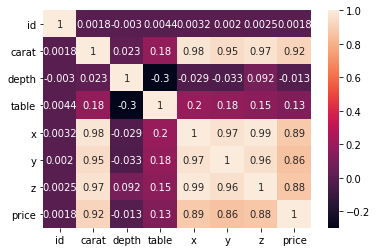

In [9]:
c=diamons.corr()
sns.heatmap(c, annot=True)

Observamos que carat, x, y, z estan muy relacionadas entre si por lo que nos quedamos solo con carat que es la que mayor relación tiene con price

In [10]:
diamons.drop(columns=['id','y','z','x','depth','table'], inplace=True)

Modificamos las columnas de tipo object. Consideramos que son ordinales y no totalmente independiente entre ellas por lo que asignamos un valor propocional a cada una

In [11]:
diamons.replace({'color':{'D':7,'E':6,'F':5,'G':4,'H':3,'I':2,'J':1}}, inplace=True)
diamons.head()

,carat,cut,color,clarity,price
0,0.78,Premium,5,VS1,3446
1,0.31,Ideal,7,SI1,732
2,0.30,Ideal,5,SI1,475
3,1.04,Ideal,6,VVS2,9552
4,0.65,Ideal,1,SI1,1276


In [12]:
diamons.replace({'cut':{'Premium':5,'Ideal':4,'Very Good':3,'Good':2,'Fair':1}}, inplace=True)
diamons.replace({'clarity':{'IF':8, 'VVS1':7, 'VVS2':6,'VS1':5,'VS2':4,'SI1':3,'SI2':2,'I1':1}}, inplace=True)
diamons.head()

,carat,cut,color,clarity,price
0,0.78,5,5,5,3446
1,0.31,4,7,3,732
2,0.30,4,5,3,475
3,1.04,4,6,6,9552
4,0.65,4,1,3,1276


Estandarizamos las features 

In [13]:
X = diamons.drop(columns=["price"])
y = diamons['price']
tr = StandardScaler()
Xpr = tr.fit_transform(X)
Xpr = pd.DataFrame(Xpr,columns=X.columns)
Xpr.head()

,carat,cut,color,clarity
0,-0.037316,1.208188,0.348974,0.571902
1,-1.028243,0.232872,1.524998,-0.639490
2,-1.049327,0.232872,0.348974,-0.639490
3,0.510857,0.232872,0.936986,1.177599
4,-0.311402,0.232872,-2.003073,-0.639490


Presentamos nuestro dataframe final con el que vamos a entrenar el modelo 

In [14]:
diamons_n = pd.concat([Xpr,y], axis=1, sort =False)
diamons_n.head()

,carat,cut,color,clarity,price
0,-0.037316,1.208188,0.348974,0.571902,3446
1,-1.028243,0.232872,1.524998,-0.639490,732
2,-1.049327,0.232872,0.348974,-0.639490,475
3,0.510857,0.232872,0.936986,1.177599,9552
4,-0.311402,0.232872,-2.003073,-0.639490,1276


## RANDOM FOREST SKLEARN

In [15]:
X = diamons.drop(columns=["price"])
y = diamons['price']
X_train, X_test, y_train, y_test = train_test_split(Xpr, y, test_size=0.2)
X_train.head()

,carat,cut,color,clarity
2697,-0.627656,-1.717761,0.936986,-0.639490
36284,-1.091494,-0.742444,0.936986,1.177599
11004,-0.184901,1.208188,0.348974,0.571902
33110,-0.184901,0.232872,-1.415062,-0.033794
11223,-0.501154,1.208188,1.524998,-0.033794


In [16]:
rf_reg = RandomForestRegressor(n_estimators=150, max_depth=15, min_samples_leaf=5, random_state=111)

In [17]:
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

In [18]:
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE 553.3005088850767


In [19]:
final = pd.DataFrame(y_pred, columns=['price'])

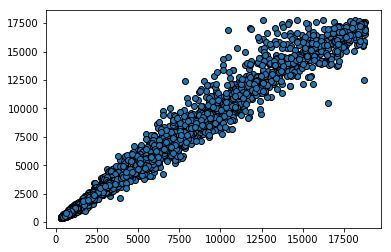

In [20]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))

## RANDOM FOREST H20

In [21]:
h2o.init(ip="127.0.0.1", port="8080")
data = h2o.H2OFrame(diamons_n)
# Input parameters that are going to train
training_columns = ['carat', 'cut', 'color','clarity']
# Output parameter train against input parameters
response_column = 'price'
train, test = data.split_frame(ratios=[0.8])
model = H2ORandomForestEstimator(ntrees=200, max_depth=20, nfolds=20)
model.train(x=training_columns, y=response_column, training_frame=train)
performance = model.model_performance(test_data=test)

Checking whether there is an H2O instance running at http://127.0.0.1:8080 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu119.10.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu119.10.1, mixed mode, sharing)
  Starting server from /home/elisa/.local/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpia1euvw4
  JVM stdout: /tmp/tmpia1euvw4/h2o_elisa_started_from_python.out
  JVM stderr: /tmp/tmpia1euvw4/h2o_elisa_started_from_python.err
  Server is running at http://127.0.0.1:8080
Connecting to H2O server at http://127.0.0.1:8080 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Madrid
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_elisa_1nsjsw
H2O cluster total nodes:,1
H2O cluster free memory:,3.885 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [22]:
performance


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 2006404.791524247
RMSE: 1416.4761881246882
MAE: 932.5298410323979
RMSLE: 0.51913957110548
Mean Residual Deviance: 2006404.791524247


## H2O XGBoost Estimator

In [23]:
from h2o.estimators.xgboost import H2OXGBoostEstimator
gbm = H2OXGBoostEstimator()
gbm.train(x=training_columns, y=response_column, training_frame=train)
y_pred2 = gbm.predict(test)
gbm

xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1583093959941_2


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 237638.5257519522
RMSE: 487.48182094510173
MAE: 261.73097899037197
RMSLE: 0.09980581656303092
Mean Residual Deviance: 237638.5257519522

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-03-01 21:21:14,0.035 sec,0.0,5590.944691,3916.393444,3.125866e+07
1,,2020-03-01 21:21:14,0.477 sec,1.0,3961.836724,2744.520443,1.569615e+07
2,,2020-03-01 21:21:14,0.575 sec,2.0,2830.994073,1923.485062,8.014527e+06
3,,2020-03-01 21:21:14,0.672 sec,3.0,2049.916362,1350.347375,4.202157e+06
4,,2020-03-01 21:21:15,0.788 sec,4.0,1514.249701,958.440929,2.292952e+06
5,,2020-03-01 21:21:15,0.888 sec,5.0,1156.736242,701.036536,1.338039e+06
6,,2020-03-01 21:21:15,0.980 sec,6.0,919.466181,538.301374,8.454181e+05
7,,2020-03-01 21:21:15,1.087 sec,7.0,770.748775,438.776672,5.940537e+05
8,,2020-03-01 21:21:15,1.183 sec,8.0,677.565624,378.239972,4.590952e+05
9,,2020-03-01 21:21:15,1.283 sec,9.0,620.845919,341.464669,3.854497e+05



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,carat,8.868887e+11,1.000000,0.898823
1,clarity,6.475207e+10,0.073010,0.065623
2,color,3.183973e+10,0.035900,0.032268
3,cut,3.241322e+09,0.003655,0.003285


In [24]:
#print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred2)))

# TEST

repetimos la misma limpieza realizada al dataframe con el que hemos entrenado el modelo, pero al que vamos usar para predecir

In [25]:
diamons_test1 = pd.read_csv('INPUT/diamonds_test.csv')
diamons_test1.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,1.10,Premium,H,SI2,62.2,58.0,6.69,6.60,4.13
1,1,0.51,Ideal,I,SI1,62.5,57.0,5.07,5.10,3.18
2,2,2.03,Premium,G,SI1,61.9,59.0,8.14,8.09,5.02
3,3,1.21,Premium,F,SI1,60.0,60.0,6.96,6.91,4.16
4,4,0.55,Ideal,F,SI1,61.8,55.0,5.27,5.22,3.24


In [26]:
diamons_test = diamons_test1.drop(columns=['id','y','z','x','depth','table'])
diamons_test.replace({'color':{'D':7,'E':6,'F':5,'G':4,'H':3,'I':2,'J':1}}, inplace=True)
diamons_test.replace({'cut':{'Premium':5,'Ideal':4,'Very Good':3,'Good':2,'Fair':1}}, inplace=True)
diamons_test.replace({'clarity':{'IF':8, 'VVS1':7, 'VVS2':6,'VS1':5,'VS2':4,'SI1':3,'SI2':2,'I1':1}}, inplace=True)
tr = StandardScaler()
Xpr_test = tr.fit_transform(diamons_test)
Xpr_test = pd.DataFrame(Xpr_test,columns=diamons_test.columns)

In [27]:
Xpr_test.head()

,carat,cut,color,clarity
0,0.641654,1.206931,-0.825150,-1.248447
1,-0.612003,0.235710,-1.412535,-0.636553
2,2.617757,1.206931,-0.237766,-0.636553
3,0.875386,1.206931,0.349618,-0.636553
4,-0.527010,0.235710,0.349618,-0.636553


In [28]:
rf_reg = RandomForestRegressor(n_estimators=150, max_depth=15, min_samples_leaf=5, random_state=111)
rf_reg.fit(Xpr, y)
y_pred = rf_reg.predict(Xpr_test)
y_pred
diamons_s = pd.DataFrame(y_pred, columns=['price'])
diamons_final = diamons_s.reset_index().rename(columns={'index':'id'})
diamons_final.to_csv('OUTPUT/final_sklearn.csv',index=False)

## TEST H20

In [29]:
train = h2o.H2OFrame(diamons_n)
test = h2o.H2OFrame(Xpr_test)
# Input parameters that are going to train
training_columns = ['carat', 'cut', 'color','clarity']
response_column = 'price'
gbm = H2OXGBoostEstimator()
gbm.train(x=training_columns, y=response_column, training_frame=train)
y_pred2 = gbm.predict(test)
gbm

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1583093959941_3


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 244712.9381845095
RMSE: 494.68468561752496
MAE: 263.7480002692234
RMSLE: 0.10097490034663482
Mean Residual Deviance: 244712.9381845095

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-03-01 21:21:26,0.013 sec,0.0,5604.472417,3931.402243,3.141011e+07
1,,2020-03-01 21:21:26,0.336 sec,1.0,3970.523114,2754.415180,1.576505e+07
2,,2020-03-01 21:21:26,0.413 sec,2.0,2836.986294,1929.909199,8.048491e+06
3,,2020-03-01 21:21:26,0.489 sec,3.0,2055.721888,1354.711481,4.225992e+06
4,,2020-03-01 21:21:27,0.564 sec,4.0,1519.368447,961.906537,2.308480e+06
5,,2020-03-01 21:21:27,0.642 sec,5.0,1158.344376,704.411804,1.341762e+06
6,,2020-03-01 21:21:27,0.723 sec,6.0,921.027966,539.889016,8.482925e+05
7,,2020-03-01 21:21:27,0.812 sec,7.0,772.776473,440.316960,5.971835e+05
8,,2020-03-01 21:21:27,0.902 sec,8.0,679.471042,379.107852,4.616809e+05
9,,2020-03-01 21:21:27,0.986 sec,9.0,622.545821,342.210047,3.875633e+05



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,carat,1.112878e+12,1.000000,0.897978
1,clarity,8.275630e+10,0.074362,0.066776
2,color,3.969792e+10,0.035671,0.032032
3,cut,3.983845e+09,0.003580,0.003215


In [33]:
final = y_pred2.rename(columns={'predict':'price'})
h2o.export_file(final, 'submission2.csv')

Export File progress: |███████████████████████████████████████████████████| 100%


In [34]:
diamons_s = pd.read_csv('submission2.csv')
diamons_final = diamons_s.reset_index().rename(columns={'index':'id'})
diamons_final.to_csv('OUTPUT/final_h20.csv',index=False)